In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# to avoid kernel dying because of library dependency issues


In [2]:
import numpy as np 
import torch

# **Pre-Processing the data**

1. Starting with loading the binary file dataset having the images in the binary format with pixel values of 28x28 images in 8 bits, for 60K such images.
2. After confirming the dataset is loaded, we convert the np tensor to torch tensor for further processing
3. flatten the images loaded in tensor for making the neural network


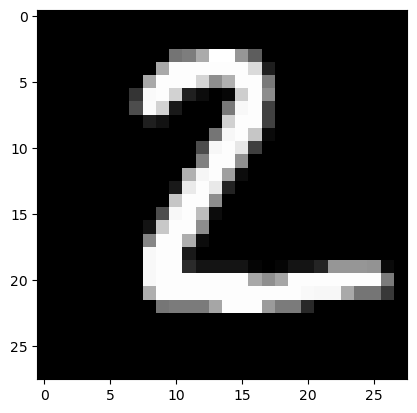

In [3]:
import matplotlib.pyplot as plt

def load_images(filename):
    with open(filename, 'rb') as f: # the given dataset is in binary stream format
        # Read magic number and number of images which are present in first 8 bytes
        magic, num_images = np.frombuffer(f.read(8), dtype='>i4')
        # Read dimensions
        rows, cols = np.frombuffer(f.read(8), dtype='>i4') # > means big endian type data, i4 integer 4 bytes.
        # Read pixel data
        data = np.frombuffer(f.read(), dtype=np.uint8) # reads the data having each pixel value in grayscale format 0~255.
        return data.reshape(num_images, rows, cols) #(60000,28,28) from a stream to a matrix of image, each value corresponding to a pixel value in 28x28 grid.
    
def load_labels(filename):
    with open(filename, 'rb') as f:
        # Magic number and number of labels
        magic, num_labels = np.frombuffer(f.read(8), dtype='>i4')
        return np.frombuffer(f.read(), dtype=np.uint8)

label_path = r"C:\Users\kumar\Desktop\DL_Lab\Lab1_2\Dataset\train-labels.idx1-ubyte"

train_file_path = r"C:\Users\kumar\Desktop\DL_Lab\Lab1_2\Dataset\train-images.idx3-ubyte"
test_file_path = r"C:\Users\kumar\Desktop\DL_Lab\Lab1_2\Dataset\t10k-images.idx3-ubyte"

train_images = load_images(train_file_path)
test_images = load_images(test_file_path)
# TEST
plt.imshow(test_images[1], cmap='gray') #color map 
plt.show()

In [4]:
train = torch.from_numpy(train_images).float()
labels_train = torch.from_numpy(load_labels(label_path))
#normalize
train /= 255.0
print(train.shape) 
print(labels_train.shape)
# now we reshape the tensor obtained above (of images) to a tensor of shape [-1,29*28] basically flattening the images to a single 1D vector
train = train.view(-1,28*28)
print(train.shape) # 60,000 vectors of dim 784
print(train[0])

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([60000, 784])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

C:\Users\kumar\AppData\Local\Temp\ipykernel_14008\3549561355.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  train = torch.from_numpy(train_images).float()


## **Model Definition**

1. The FCNN consists of input layer of 784 neurons, followed by two layers with 16 neurons each and then finally output layer with 10 classes 
2. the ReLU activation function is used in each layer and the output layer has softmax function to get the probability distribution   

In [5]:
import torch.nn as nn

class MNIST_NeuralNetwork(nn.Module):
    def __init__(self,in_l=784, h1=32, h2=16, classes = 10):
        super(MNIST_NeuralNetwork,self).__init__()

        self.layer1 = nn.Linear(in_l,h1)
        self.relu1 = nn.ReLU()

        self.layer2 = nn.Linear(h1,h2)
        self.relu2 = nn.ReLU()

        self.output = nn.Linear(h2,classes)

    def forward(self,x): #x is the input vector 
        out = self.relu1(self.layer1(x))
        out = self.relu2(self.layer2(out))
        out = self.output(out)
        return out

digitModel = MNIST_NeuralNetwork()
print(digitModel)

MNIST_NeuralNetwork(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=16, out_features=10, bias=True)
)


In [6]:
# defining the loss function and the required optimizer 
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # directly takes the sigmoid of the output layer and applies the cross entropy loss function
optimizer = optim.Adam(digitModel.parameters(),lr=0.003) # optimizing using the Adaptive Moments algo with the eta = 0.003


In [ ]:
batch_size = 64 # mini batch grad-descent with Adam optimization
epochs = 12 # go thru the whole data 16 times , shuffled randomly to generalize the model better.

for epoch in range(epochs):
    permutation = torch.randperm(train.size(0)) # shuffle for each epoch
    for i in range(0, len(train), batch_size):
        indices = permutation[i : i + batch_size] # take the minibatch 
        x_batch = train[indices]
        y_batch = labels_train[indices]
        #training 
        optimizer.zero_grad() # initialize the gradients to 0, as gamma_0 and v_0 are 0 at the start (see notes)
        outs = digitModel(x_batch) # forward pass
        loss = criterion(outs, y_batch) # loss calc
        loss.backward()# backprop
        optimizer.step() # update after minibatch is traversed
    
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}') 

Epoch [1/16], Loss: 0.3101
Epoch [2/16], Loss: 0.0425
Epoch [3/16], Loss: 0.0195
Epoch [4/16], Loss: 0.3615
Epoch [5/16], Loss: 0.1019
Epoch [6/16], Loss: 0.1043
Epoch [7/16], Loss: 0.0103
Epoch [8/16], Loss: 0.1082
Epoch [9/16], Loss: 0.0918
Epoch [10/16], Loss: 0.0668
Epoch [11/16], Loss: 0.0714
Epoch [12/16], Loss: 0.0263
Epoch [13/16], Loss: 0.0753
Epoch [14/16], Loss: 0.0217
Epoch [15/16], Loss: 0.0132
Epoch [16/16], Loss: 0.0029


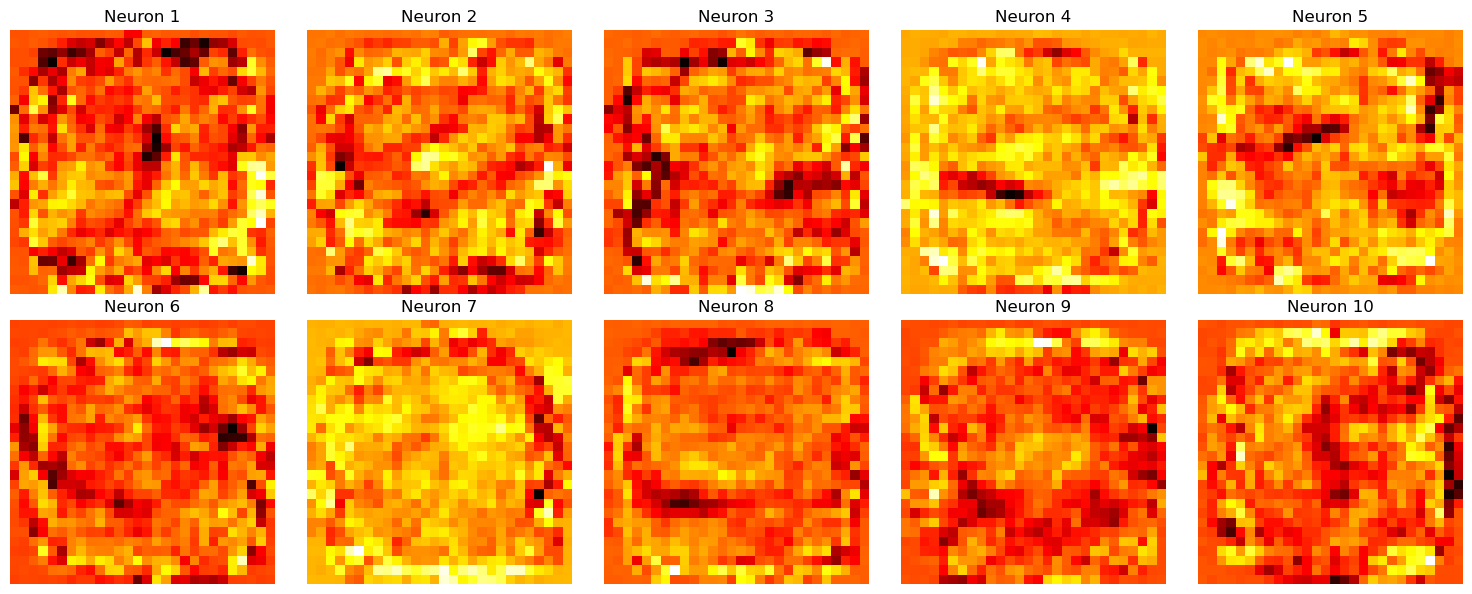

In [8]:
import matplotlib.pyplot as plt

# 1. Extract weights from the first hidden layer
# layer1.weight has shape [h1, 784] -> [16, 784]
weights = digitModel.layer1.weight.data

# 2. Visualize 10 different neurons
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1) # access each supplot location
    # Reshape the 784-length weight vector back to 28x28 grid
    # This is the reverse of the flattening
    neuron_weight = weights[i].reshape(28, 28) # plot the heat map of ith neuron
    plt.imshow(neuron_weight, cmap='hot') # Heatmap visualization
    plt.title(f'Neuron {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
test_tensor = torch.from_numpy(test_images).float() / 255.0

#Flatten [10000, 28, 28] -> [10000, 784]
test_flattened = test_tensor.view(-1, 28*28)

test_label_path = r"C:\Users\kumar\Desktop\DL_Lab\Lab1_2\Dataset\t10k-labels.idx1-ubyte"
labels_test = torch.from_numpy(load_labels(test_label_path))

In [10]:
digitModel.eval() # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    outputs = digitModel(test_flattened)
    
    predicted = torch.max(outputs.data, 1)[1]
    total = labels_test.size(0)
    correct = (predicted == labels_test).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {accuracy:.2f}%')

Accuracy of the network on the 10,000 test images: 96.42%


## **Part 2.2\) Training on Scrambled data**

torch.Size([60000, 28, 28])
torch.Size([60000])


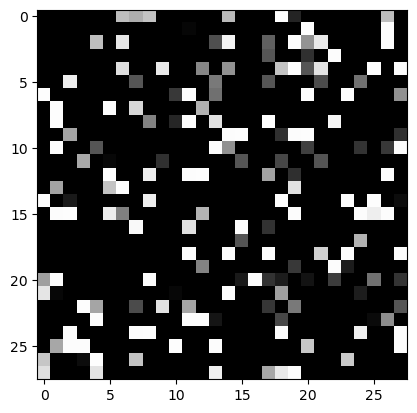

In [27]:
train2 = torch.from_numpy(train_images).float()
labels_train2 = torch.from_numpy(load_labels(label_path))
#normalize
train2 /= 255.0

print(train2.shape) 
print(labels_train2.shape)
# now we reshape the tensor obtained above (of images) to a tensor of shape [-1,29*28] basically flattening the images to a single 1D vector
train2 = train2.view(-1,28*28)
indices = torch.randperm(train2.size(1))
train_scrambled = train2[:,indices]

test_im = train_scrambled[1]
test_im = test_im.reshape(28,28)
plt.imshow(test_im, cmap='gray') #color map 
plt.show()


In [42]:
scrambled_model = MNIST_NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(scrambled_model.parameters(),lr = 0.001)

In [49]:
epochs = 12
batch_size = 128

for epoch in range(epochs):
    perm = torch.randperm(train_scrambled.size(0))
    for i in range(0,train_scrambled.size(0),batch_size):
        x_b = train_scrambled[perm[i:i+batch_size]]
        y_b = labels_train[perm[i:i+batch_size]]

        optimize = optimizer.zero_grad()
        outputs = scrambled_model(x_b)
        loss = criterion(outputs,y_b)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/12], Loss: 0.1533
Epoch [2/12], Loss: 0.2609
Epoch [3/12], Loss: 0.1968
Epoch [4/12], Loss: 0.0719
Epoch [5/12], Loss: 0.1251
Epoch [6/12], Loss: 0.0795
Epoch [7/12], Loss: 0.1877
Epoch [8/12], Loss: 0.0473
Epoch [9/12], Loss: 0.1850
Epoch [10/12], Loss: 0.0503
Epoch [11/12], Loss: 0.0834
Epoch [12/12], Loss: 0.1106


In [50]:
test_flattened2 = test_flattened[:,indices]

scrambled_model.eval()
correct = 0
total = 0

with torch.no_grad():
    outputs = scrambled_model(test_flattened2)
    
    predicted = torch.max(outputs.data, 1)[1]
    total = labels_test.size(0)
    correct = (predicted == labels_test).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {accuracy:.2f}%')

Accuracy of the network on the 10,000 test images: 96.03%
